### Анализ данных в задаче кредитного скоринга

In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Загружаем исходные данные

data = pd.read_csv('credit_card_default_analysis.csv', sep = ',', header = 0)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Задание 1: 
##### В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

#### Задание 1(a):
Для ответа на вопрос (а) используем оценку с помощью доверительных интервалов на основе бутстрепа.

Сначала посмотрим на данные - оценим размер выборок значений кредитного лимита для тех, кто вернул кредит, и значений кредитного лимита для тех, кто не вернул кредит:

In [3]:
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

Размеры выборок существенно отличаются, но в таких условиях также можно сравнивать медианные значения. Так как мы будем проверять гипотезы о медианах выборок и распределениях значений, полезно построить boxplot-графики и гистограммы.

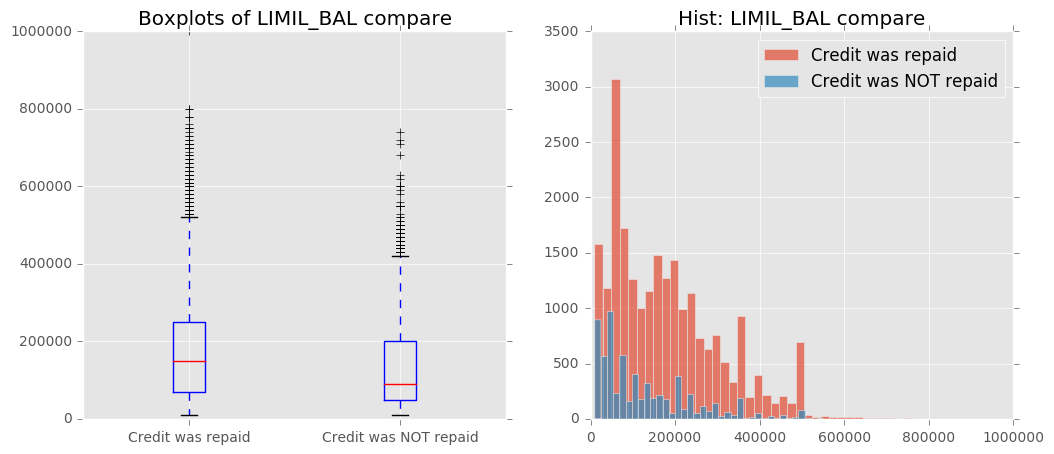

In [4]:
pylab.figure(figsize=(12,5))
pylab.grid(1)

pylab.subplot(1,2,1)
plt.boxplot([data[data.default == 0].LIMIT_BAL.values, data[data.default == 1].LIMIT_BAL.values], positions = [1,2])
plt.xticks([1, 2], ['Credit was repaid', 'Credit was NOT repaid'])
plt.title('Boxplots of LIMIL_BAL compare')

pylab.subplot(1,2,2)
pyplot.hist(data[data.default == 0].LIMIT_BAL.values, bins = 50, alpha=0.7, label='Credit was repaid')
pyplot.hist(data[data.default == 1].LIMIT_BAL.values, bins = 50, alpha=0.7, label='Credit was NOT repaid')

plt.title('Hist: LIMIL_BAL compare')
pyplot.legend(loc='upper right')
pyplot.show()

На данных графиках видно, что распределения имеют разные медианы. Чтобы в этом убедиться, построим доверительные интервалы на основе бутстрепа для медиан обоих распределений:

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(0)

ret_median_scores = map(np.median, get_bootstrap_samples(data[data.default == 0].LIMIT_BAL.values, 1000))
non_ret_median_scores = map(np.median, get_bootstrap_samples(data[data.default == 1].LIMIT_BAL.values, 1000))

print '95% confidence interval for the "Credit was repaid" median:',  stat_intervals(ret_median_scores, 0.05)
print '95% confidence interval for the "Credit was not repaid" median:',  stat_intervals(non_ret_median_scores, 0.05)

95% confidence interval for the "Credit was repaid" median: [ 150000.  150000.]
95% confidence interval for the "Credit was not repaid" median: [ 80000.  90000.]


Т.к. интервалы не пересекаются, и в первом случае мы получили точечную оценку => будем проверять гипотезу:

$H_0\colon \theta = \theta_{0}$ 

$H_1\colon \theta\neq \theta_{0}$ 

$H_0$ отвергается на уровне значимости 0.05, если 95% доверительный интервал для $\theta$ не содержит $\theta_{0}$

#### Ответ 1(a): 

Мы можем отвергнуть гипотезу о равенстве медиан, т.к. доверительный интервал для медианы значений кредитного лимита для тех, кто не вернул кредит, не содержит значение $\theta_{0} = 150000$. 

#### Задание 1(b):

На графике распределений двух выборок видно, что они не совпадают. Чтобы это доказать используем перестановочный критерий для независимых выборок:

Проверять будем нулевую гипотезу о том, что функции распределения значений кредитного лимита для тех, кто вернул кредит и для тех, кто его не вернул одинаковы (совпадают):

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

Против альтернативы, что функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке.

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [6]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
np.random.seed(0)

print 'Statistical significance p-value:', permutation_test(data[data.default == 0].LIMIT_BAL.values, 
                                                            data[data.default == 1].LIMIT_BAL.values, 
                                                            max_permutations = 3000) 

Statistical significance p-value: 0.000333333333333


#### Ответ 1(b) : 

Так как значение p-value намного меньше $\alpha$ - мы можем отвергнуть гипотезу о равенстве распределений на уровне значимости 0.05.

##### Размер эффекта:

Размер эффекта - это степень отклонения данных от нулевой гипотезы. Данная величина определена на генеральной совокупности. Но у нас есть только небольшая выборка из нее, а оценка размера эффекта по выборке — это случайная величина. Маленький достигаемый уровень значимости является показателем того, что такую оценку размера эффекта, какая получена по выборке, с маленькой вероятностью можно было получить случайно.

С полученным p-value так и есть.

Достигаемый уровень значимости зависит не только от размера эффекта, но и от объема выборки, по которой оценивается эффект. На небольших выборках, нулевая гипотеза, скорее всего,отвергается. Однако с ростом объема выборки начинают проявляться все более тонкие отклонения данных от нулевой гипотезы. Велика вероятность, что на достаточно большой выборке значительная часть разумных нулевых гипотез будет отвергнута. Именно поэтому, даже если нулевая гипотеза отвергнута, это еще не значит, что полученный эффект имеет какую-то практическую значимость, её нужно оценивать отдельно. 

Несмотря на то, что мы имеем выборки достаточного размера: N_non_ret = 6636, R_ret = 23364. Оценим практическую значимость исходя из здравого смысла )

##### Практическая значимоcть результатов:

Результат (a): сравнение медианных значений этих двух выборок и проверка распределений - сложно назвать практически значимыми, т.к. в случае (а) мы ответили на вопрос о том, что средние отличаются, но не определяли: в какую сторону. Соответственно, при данной проверке мы не можем сделать практически значимый вывод, например, о прибыльности данного банка. 
В данную случае простой boxplot, показанный ранее, имеет большую практическую значимость.

Результат (b): в случае (b) мы установили, что обе выборки имеют похожий вид распределения, но имеют сдвиг относительно друг друга на некоторую величину => данный результат не несет большого смысла сам по себе. Сравнительный график гистограмм дает больше информации, например, о том, что доля невыплаченных кредитов в несколько раз меньше доли возвращенных.

----------------------------------------------------------------------------------------------------------------------
#### Задание 2:

###### Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

Для ответа на этот вопрос нужно проверить гипотезу о равенстве долей полов в обоих выборках. 

$H_0$ - доли обоих полов равны 

$H_1$ - доли обоих полов не равны

Всегда полезно посмотреть на данные, с которыми будем работать, поэтому построим интересующие нас доли в двух выборках.

In [13]:
# составим сводную таблицу по полу и индикатору возврата кредита

people = data.pivot_table(index = 'SEX', columns = 'default', values = 'ID', aggfunc = 'count').fillna(0)
people

default,0,1
SEX,,
1,9015,2873
2,14349,3763


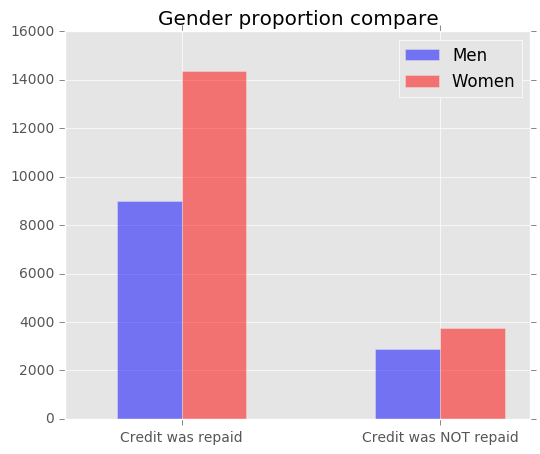

In [58]:
pylab.figure(figsize=(6,5))
pylab.grid(1)

index = list([1,2])
width = 0.25
opacity = 0.5

men = [people[0][1], people[1][1]]
women = [people[0][2], people[1][2]]
 
plt.bar(index, men, width, alpha=opacity, color='b', label='Men')
plt.bar([i + width for i in index], women, width, alpha=opacity, color='red', label='Women')

plt.xticks([1.25, 2.25], ['Credit was repaid', 'Credit was NOT repaid'])

plt.title('Gender proportion compare')
plt.legend(loc='upper right')
plt.show()

По графику уже видно, что отношения долей существенно отличаются. Чтобы это доказать, проведем дополнительные исследования - интервальную оценку и Z-критерий для долей.

#### Интервальная оценка:

Построим доверительные интервалы для этих долей:

In [21]:
from statsmodels.stats.proportion import proportion_confint

# оценим доли полов среди обоих выборок
conf_interval_g = proportion_confint(people[0][1], 
                                            sum(people[0]),
                                            method = 'wilson')
conf_interval_b = proportion_confint(people[1][1], 
                                            sum(people[1]),
                                            method = 'wilson')
print 'Interval in Repaid credits [%f, %f]' % conf_interval_g
print 'Interval in Non repaid credits [%f, %f]' % conf_interval_b

Interval in Repaid credits [0.379627, 0.392110]
Interval in Non repaid credits [0.421062, 0.444898]


Как видно, доверительные интервалы не пересекаются => можно сказать, что доли не равны. Чтобы в этом убедиться, построим доверительный интервал разности долей для независимых выборок.

In [25]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

# для удобства преобразуем выборки в бинарные
good_people = [1 if x == 2 else 0 for x in data[data.default == 0].SEX]
bad_people = [1 if x == 2 else 0 for x in data[data.default == 1].SEX]

print '95%% confidence interval for a difference between proportions: [%f, %f]' %\
                                    proportions_diff_confint_ind(good_people, bad_people)

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


Данный доверительный интервал довольно узкий (что означает, что оценка точная), лежит полностью правее нуля и не содержит его => мы можем утверждать, что доли отличаются. 

#### Z-критерий:

Эту же гипотезу о равенстве долей против двусторонней альтернативы, что доли не равны, можно проверить еще одним способом: с помощью Z-критерия для разности долей для независимых выборок.

Для его рассчета используем следующую матрицу:

  | $default = 1$ | $default = 0$  
  ------------- | -------------|
  SEX = 1  | 2873 | 9015 
  SEX = 2  | 3763 | 14349 
  $\sum$ | 6636| 23364

In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

p = proportions_diff_z_test(proportions_diff_z_stat_ind(good_people, bad_people),'two-sided')
print 'p-value:', p

p-value: 4.47286652161e-12


Полученное значение p-value намного меньше 0.05, что позволяет отвергнуть нулевую гипотезу в пользу альтернативы и сделать вывод, что доли не равны.

#### Ответ 2:

На уровне значимости 0.05 можно сделать вывод о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

----------------------------------------------------------------------------------------------------------------------

#### Задание 3:
##### Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? Наоборот, не отдаст долг?

Мы хотим проверить гипотезу о том, что образование клиента не влияет на то, вернет ли человек долг.

Для этого мы применим критерий хи-квадрат: 
построим таблицы сопряженности между каждой из всех возможных неупорядоченных пар категорий образования и значений признака default и оценим - сколько достигаемых уровней значимости оказались меньше, чем $\alpha$=0.05?

Начнем с таблицы сопряженности "образование" на "возврат долга", где значение ячейки это разность между наблюдаемым и ожидаемым количеством человек.

Для этого применим функцию
stats.chi2_contingency(subtable) - которая возвращает в т.ч. и ожидаемое распределение

In [27]:
obs_edu = data.pivot_table(index = 'EDUCATION', columns = 'default', values = 'ID', aggfunc = 'count').fillna(0)
exp_edu = pd.DataFrame(stats.chi2_contingency(obs_edu, correction = False)[3], columns = obs_edu.columns, index = obs_edu.index)

diff_edu = obs_edu - exp_edu
diff_edu

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


В полученной таблице получились одинаковые по модулю значения разностей, но не будем забывать, что начальные значения имеют разный масштаб. Посмотрим на графики распределений:

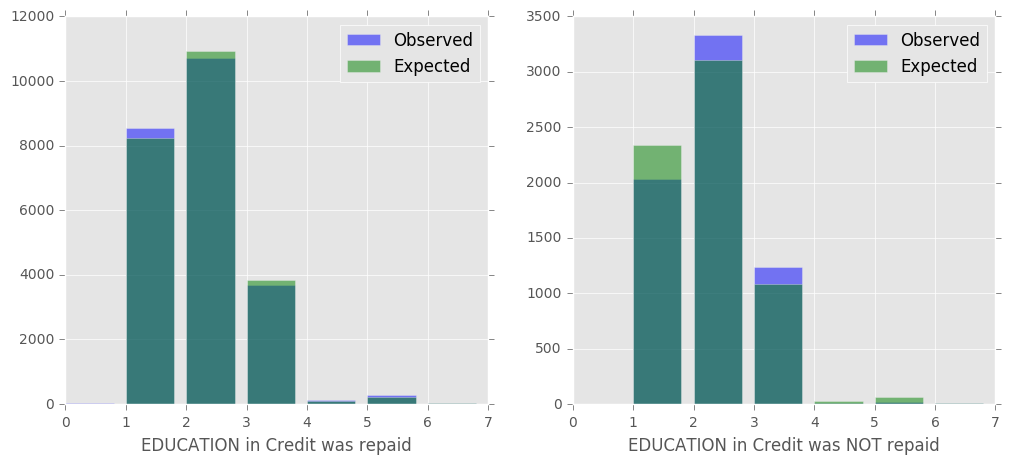

In [28]:
pylab.figure(figsize=(12,5))
pylab.grid(1)

pylab.subplot(1,2,1)
plt.bar(np.arange(obs_edu.shape[0]), obs_edu[0], color = 'b', alpha = 0.5, label = 'Observed')
plt.bar(np.arange(exp_edu.shape[0]), exp_edu[0], color = 'g', alpha = 0.5, label = 'Expected')
plt.xlabel('EDUCATION in Credit was repaid')
plt.legend()

pylab.subplot(1,2,2)
plt.bar(np.arange(obs_edu.shape[0]), obs_edu[1], color = 'b', alpha = 0.5, label = 'Observed')
plt.bar(np.arange(exp_edu.shape[0]), exp_edu[1], color = 'g', alpha = 0.5, label = 'Expected')
plt.xlabel('EDUCATION in Credit was NOT repaid')

plt.legend()
pyplot.show()

##### Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? 

#### Ответ:
Чтобы сравнивать значения обеих групп необходимо привести их к одному масштабу не потеряв в интерпретируемости => прологарифмируем значения распределений EDUCATION и оценим результат.

In [29]:
l_obs_edu = obs_edu.apply(np.log)
l_exp_edu = exp_edu.apply(np.log)

l_diff_edu = l_obs_edu - l_exp_edu
l_diff_edu

default,0,1
EDUCATION,,
0,0.250001,-inf
1,0.036377,-0.139763
2,-0.020953,0.070462
3,-0.039785,0.128679
4,0.191407,-1.357586
5,0.183556,-1.235730
6,0.079375,-0.343696


Теперь отличия ожидаемых значений от наблюдаемых стали отличаться не только по направлению, но и по размеру. Убедимся в этом на графике (обратите внимание на масштаб по оси Y)

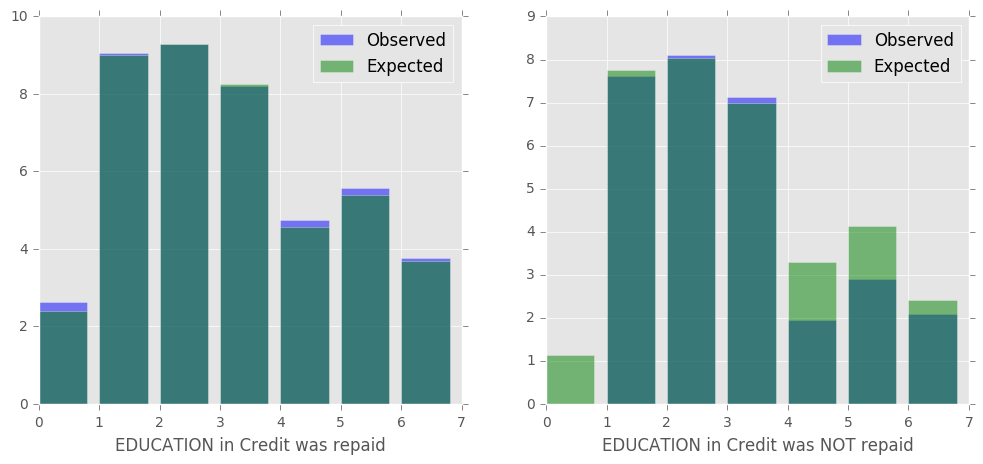

In [30]:
pylab.figure(figsize=(12,5))
pylab.grid(1)

pylab.subplot(1,2,1)
plt.bar(np.arange(l_obs_edu.shape[0]), l_obs_edu[0], color = 'b', alpha = 0.5, label = 'Observed')
plt.bar(np.arange(l_exp_edu.shape[0]), l_exp_edu[0], color = 'g', alpha = 0.5, label = 'Expected')
plt.xlabel('EDUCATION in Credit was repaid')
plt.legend()

pylab.subplot(1,2,2)
plt.bar(np.arange(l_obs_edu.shape[0]), l_obs_edu[1], color = 'b', alpha = 0.5, label = 'Observed')
plt.bar(np.arange(l_exp_edu.shape[0]), l_exp_edu[1], color = 'g', alpha = 0.5, label = 'Expected')
plt.xlabel('EDUCATION in Credit was NOT repaid')

plt.legend()
pyplot.show()

##### Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? Наоборот, не отдаст долг?

До тех пор, пока клиент не вернул кредит, мы можем оценивать только ожидаемое распределение => для ответа на этот вопрос сравним отмасштабированные ожидаемые распределения образования по двум группам.

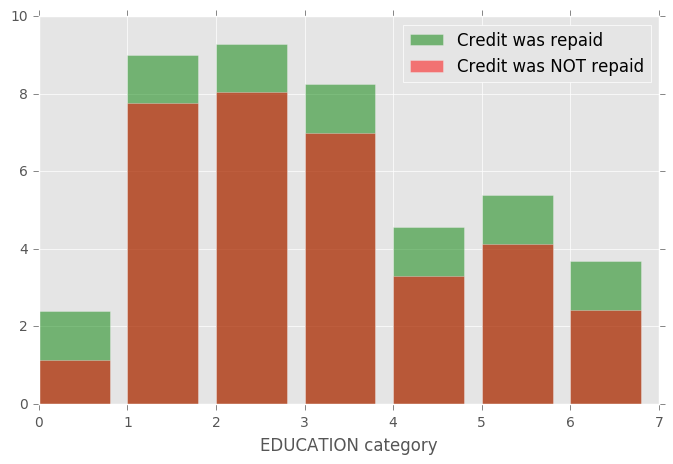

In [31]:
pylab.figure(figsize=(8,5))
pylab.grid(1)

plt.bar(np.arange(exp_edu.shape[0]), l_exp_edu[0], color = 'g', alpha = 0.5, label = 'Credit was repaid')
plt.bar(np.arange(exp_edu.shape[0]), l_exp_edu[1], color = 'r', alpha = 0.5, label = 'Credit was NOT repaid')
plt.xlabel('EDUCATION category')
plt.legend()
pyplot.show()

На графике видно, что вид разница между ожидаемыми распределениями очень похожа. Чтобы это проверить, посмотрим на разность значений по категориям образования:

In [32]:
print (l_exp_edu[1] - l_exp_edu[0])

EDUCATION
0   -1.258687
1   -1.258687
2   -1.258687
3   -1.258687
4   -1.258687
5   -1.258687
6   -1.258687
dtype: float64


Докажем равенство распределений проверкой нулевой гипотезы о том, что они равны, против альтернативы, что это не так.

Для этого мы воспользуемся критерием хи-квадрат, т.к. соблюдены следующие условия: 

$-$ нужно, чтобы выборки были достаточно большими: n ≥ 40. 
необходимо, чтобы ожидаемое количество элементов в каждой ячейке таблицы было меньше 5($\frac{n_{i+}n_{+j}}{n} &lt;5$), не более, чем в 20% ячеек.

In [52]:
edu = data.EDUCATION.unique()

results = {}
for edu1 in edu:
    for edu2 in edu:
        if edu2 <= edu1:
            continue
            
        tmp_df = data[data.EDUCATION.isin([edu1, edu2])]\
        .pivot_table(index = 'EDUCATION', columns = 'default', values = 'ID', aggfunc = 'count').fillna(0)
        results[(edu1, edu2)] = stats.chi2_contingency(tmp_df, correction=False)[1]
        
edu_df = pd.DataFrame.from_dict(results, orient = 'index')
edu_df.columns = ['p_value']
print "H0 False: ",edu_corr_df[edu_df.p_value < 0.05].shape[0]
print "H0 True: ",edu_corr_df[edu_df.p_value >= 0.05].shape[0]

H0 False:  13
H0 True:  8


Казалось бы, можно отвергнуть нулевую гипотезу о том, что распределения не равны, но интерпретация числа достигаемых уровней значимости, меньших α=0.05, некорректна, поскольку не сделана поправка на множественную проверку гипотез.

В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного Oi и ожидаемого Ei значений.

Проведем те же сравнения, но с поправкой: scipy.stats.chi2_contingency(subtable, correction=True)

In [54]:
results_corr = {}
for edu1 in edu:
    for edu2 in edu:
        if edu2 <= edu1:
            continue
            
        tmp_df = data[data.EDUCATION.isin([edu1, edu2])]\
        .pivot_table(index = 'EDUCATION', columns = 'default', values = 'ID', aggfunc = 'count').fillna(0)
        results_corr[(edu1, edu2)] = stats.chi2_contingency(tmp_df, correction=True)[1]
        
edu_corr_df = pd.DataFrame.from_dict(results_corr, orient = 'index')
edu_corr_df.columns = ['p_value']
print "H0 False: ",edu_corr_df[edu_corr_df.p_value < 0.05].shape[0]
print "H0 True: ",edu_corr_df[edu_corr_df.p_value >= 0.05].shape[0]

H0 False:  10
H0 True:  11


=> В случае с поправкой победила нулевая гипотеза и мы можем принять на уровне значимости 0.05, что распределения по образованию в обоих группах равны.

#### Ответ:
В данном случае можно сделать вывод, что от образования не зависит вернет клиент кредит или нет. Наибольшее ожидаемое количество людей, которые вернут кредит, как и тех, кто его не вернет, имеют образование бакалавра (EDUCATION = 2).

----------------------------------------------------------------------------------------------------------------------

#### Задание 4:

##### Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты.

Так как оба признака - MARRIAGE и default являются категориальными, но первый - не бинарный, то проверим их взаимосвязь с помощью коэффициента корреляции Крамера.

Этот коэффициент корню из специальным образом нормированного значения статистики хи-квадрат. Коэффициент Крамера принимает значения в интервале от 0 до 1. 0 соответствует полному отсутствию взаимосвязи, а 1 — полному совпадению переменных X1 и X2.

Если значение коэффициента достаточно велико, то нулевая гипотеза о независимости признаков должна быть отклонена в пользу двусторонней альтернативы.

Построим сводную таблицу для признака MARRIAGE и показателя default: 

In [55]:
mar = data.pivot_table(index = 'MARRIAGE', columns = 'default', values = 'ID', aggfunc = 'count').fillna(0)
mar.head()

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


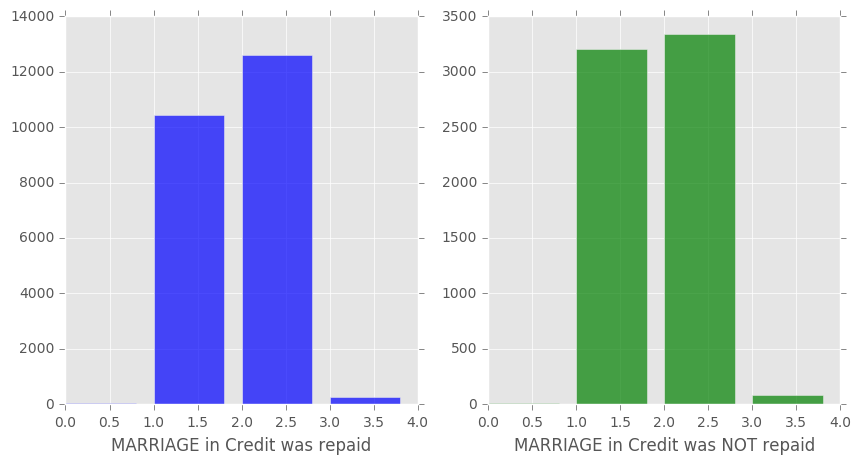

In [62]:
# Посмотрим на функции плотности распределения

pylab.figure(figsize=(10,5))
pylab.grid(1)

pylab.subplot(1,2,1)
plt.bar(np.arange(mar.shape[0]), mar[0], color = 'b', alpha = 0.7)
plt.xlabel('MARRIAGE in Credit was repaid')

pylab.subplot(1,2,2)
plt.bar(np.arange(mar.shape[0]), mar[1], color = 'g', alpha = 0.7)
plt.xlabel('MARRIAGE in Credit was NOT repaid')
pyplot.show()

In [56]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

print "Cramer's V value:",cramers_stat(mar.values)

Cramer's V value: 0.0344782036628


#### Ответ 4:

Так как коэффициент Крамера имеет небольшое значение, можно сказать, что связь между этими переменными довольно слабая.

----------------------------------------------------------------------------------------------------------------------

#### Задание 5: 
##### Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

Задание 5(a):
Как и в случае задания 1(a) lля ответа на вопрос используем оценку с помощью доверительных интервалов на основе бутстрепа
Сначала посмотрим на данные: оценим размер выборок значений возраста для тех, кто вернул кредит, и значений возраста для тех, кто не вернул кредит.

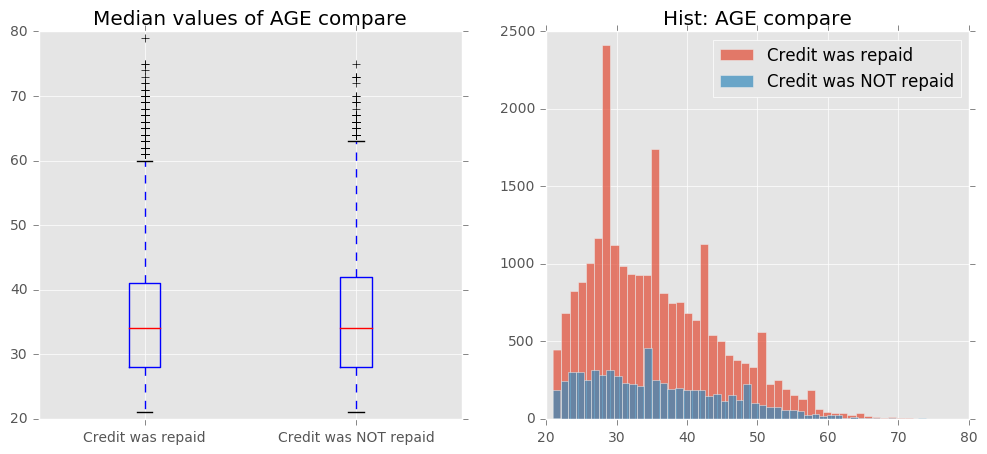

In [35]:
# посмотрим на гистограммы и медианы обоих распределений
pylab.figure(figsize=(12,5))
pylab.grid(1)

pylab.subplot(1,2,1)
plt.boxplot([data[data.default == 0].AGE.values, data[data.default == 1].AGE.values], positions = [1,2])
plt.xticks([1, 2], ['Credit was repaid', 'Credit was NOT repaid'])
plt.title('Median values of AGE compare')

pylab.subplot(1,2,2)
pyplot.hist(data[data.default == 0].AGE.values, bins = 50,  alpha=0.7, label='Credit was repaid')
pyplot.hist(data[data.default == 1].AGE.values, bins = 50,  alpha=0.7, label='Credit was NOT repaid')
plt.title('Hist: AGE compare')
pyplot.legend(loc='upper right')
pyplot.show()

plt.show()

На данных графиках видно, что медианы выборок могут совпадать. Для проверки этой гипотезы построим доверительные интервалы на основе бутстрепа для медиан обоих распределений:

In [36]:
np.random.seed(0)

ret_median_scores = map(np.median, get_bootstrap_samples(data[data.default == 0].AGE.values, 1000))
non_ret_median_scores = map(np.median, get_bootstrap_samples(data[data.default == 1].AGE.values, 1000))

print '95% confidence interval for the "Credit was repaid" median:',  stat_intervals(ret_median_scores, 0.05)
print '95% confidence interval for the "Credit was not repaid" median:',  stat_intervals(non_ret_median_scores, 0.05)

95% confidence interval for the "Credit was repaid" median: [ 34.  34.]
95% confidence interval for the "Credit was not repaid" median: [ 34.  35.]


Несмотря на то, что интервалы пересекаются, нельзя сказать, что $H_{0}$ всегда принимается:

$H_0\colon \theta_{1} = \theta_{2}$ 

$H_1\colon \theta_{1} \neq \theta_{2}$ 

Чтобы проверить эту гипотезу нужно построить доверительный интервал для разности параметров $\theta_{1}$ и $\theta_{2}$ - в этом случае мы проверяем нулевую гипотезу, что разность равна 0 против двусторонней альтернативы, что это не так. 

In [37]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(ret_median_scores, non_ret_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 0.  1.]


#### Ответ 5(a): 

95% доверительный интервал содержит 0, значит мы можем принять нулевую гипотезу на уровне значимости 0.05 и утверждать, что медианы равны.

#### Задание 5(b): 
Даже если медианы равны, это еще не гарантирует, что распределения тоже равны. Проверим гипотезу о равенстве распределений.

По гистрограммам видно, что это распределения имеют разные параметры, несмотря на совпадение медиан. Убедимся в этом с помощью перестановочного критерия для независимых выборок. Проверим нулевую гипотезу

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ - что функции распределения значений возраста для тех, кто вернул кредит и для тех, кто его не вернул одинаковы (совпадают)

Против двусторонней альтернативы: 

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$, что это не так.

In [57]:
print 'Statistical significance p-value:', permutation_test(data[data.default == 0].AGE.values, 
                                                            data[data.default == 1].AGE.values, max_permutations = 3000) 

Statistical significance p-value: 0.019


#### Ответ 5(b) : 

Так как значение p-value намного меньше $\alpha$ - мы можем отвергнуть гипотезу о равенстве распределений на уровне значимости 0.05.

##### Размер эффекта:

В отличии от Задания 1(b) - степень отклонения данных от нулевой гипотезы в данном случае меньше => больше вероятности что такую оценку размера эффекта, какая получена по выборке, можно было получить случайно. Значит можно предположить, что практическая значимость данного результат меньше.

Но размер выборки достаточно большой, поэтому, даже если нулевая гипотеза отвергнута, это еще не значит, что полученный эффект имеет какую-то практическую значимость, её нужно оценивать отдельно. 


##### Практическая значимоcть результатов:

Результат (a): практическая значимость данного результата в том, что в обоих группах половина клиентов находится в возрасте до 34 лет, а половина после => можно предположить, что возраст "среднего" клиента, взявшего кредит, равен 34 годам.

А в случае (b) мы установили, что обе выборки имеют похожий вид распределения, но имеют сдвиг относительно друг друга на некоторую величину => данный результат не несет большого смысла сам по себе, как и в случае с Заданием 1(b).